In [303]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision.transforms import functional as TF
import os
import scipy.sparse as sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from tqdm import tqdm
from PIL import Image
import numpy as np
import kornia
from mpl_toolkits.mplot3d import Axes3D
#import potpourri3d as pp3d #the python binding to GeometryCentral
#pip install potpourri3d

## The Vector Heat Method


Let's use the script steming from TP2.


In [278]:
def read_mesh(name):
    with open(name, mode="r") as file:
        
        #check type of file
        file_type = file.readline().strip()
        if file_type != "OFF":
            raise Exception("Wrong type of file, only reads OFF files")
        #number of vertices/faces/edges:
        n_verts, n_faces, n_edges = tuple([int(s) for s in file.readline().strip().split(' ')])
        #vertices
        X0 = []
        for _ in range(n_verts):
            X0.append(file.readline().strip().split(' '))
        #faces
        F = []
        for i in range(n_faces):
            F.append(file.readline().strip().split(' ')[1:])
    return np.asarray(X0).astype(float), np.asarray(F).astype(int)
def plot_mesh(X, F, subplot = [1,1,1], title="", el=0, az=0, lwdt=.1, dist=6, c="grey",
              face_func=None, vertex_func=None):
    X = X.T
    ax = plt.subplot(subplot[0],subplot[1],subplot[2], projection='3d')
    collec = ax.plot_trisurf(X[0,:], X[1,:], X[2,:], triangles=F, lw=lwdt, color=c, alpha=1)
    if face_func is not None:
        collec.set_array(face_func)
    if vertex_func is not None:
        vertex_value = lambda v: np.mean(np.stack([v[F[:,0]], v[F[:,1]], v[F[:,2]]]), axis=0)
        collec.set_array(vertex_value(vertex_func))
    ax.axis("off")
    #ax.set_aspect('equal')
    ax.view_init(elev=el, azim=az)
    ax.dist = dist
    
    # Create cubic bounding box to simulate equal aspect ratio
    # this is a hack to prevent a change in aspect ratio during rotation
    x = X[0,:]
    y = X[1,:]
    z = X[2,:]
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    plt.title(title)
    return ax #need the ax object for the last section of the lab

In [279]:
name = 'elephant-5kf.off'
#name = 'elephant-15kf.off'
#name = 'elephant-50kf.off'# turn this on ONLY AFTER completing the whole Lab
X,F = read_mesh(name)
#make sure the mesh is in the appropiate directory

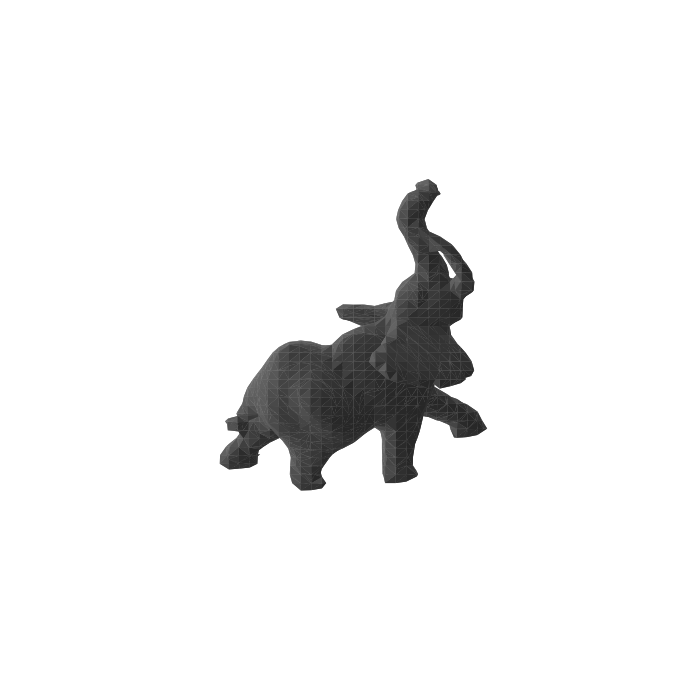

In [280]:
plt.figure(figsize=(7,7))
plot_mesh(X,F)
plt.tight_layout()
plt.show()

Analogous to the practical session, we compute the connection laplacian.

In [287]:


def compute_connection_laplacian(X, F):
    num_vertices = len(X)
    L = sparse.lil_matrix((num_vertices, num_vertices))
    L_grad = sparse.lil_matrix((num_vertices, num_vertices))
    M = np.zeros(num_vertices)

    for i in range(len(F)):
        # Get the indices of the vertices of the current face
        i1, i2, i3 = F[i]
        v1, v2, v3 = X[i1], X[i2], X[i3]

        # Compute normalized inner angles
        theta_i = np.arccos(np.dot(v2 - v1, v3 - v1) / (np.linalg.norm(v2 - v1) * np.linalg.norm(v3 - v1)))
        theta_j = np.arccos(np.dot(v3 - v2, v1 - v2) / (np.linalg.norm(v3 - v2) * np.linalg.norm(v1 - v2)))
        theta_k = np.arccos(np.dot(v1 - v3, v2 - v3) / (np.linalg.norm(v1 - v3) * np.linalg.norm(v2 - v3)))
        Theta_i = theta_i + theta_j + theta_k

        # Compute normalized angles
        tilde_theta_i_j = 2 * np.pi * theta_i / Theta_i
        tilde_theta_j_k = 2 * np.pi * theta_j / Theta_i
        tilde_theta_k_i = 2 * np.pi * theta_k / Theta_i

        # Compute angle of edge ij_a
        phi_ij = tilde_theta_i_j
        phi_jk = tilde_theta_j_k
        phi_ki = tilde_theta_k_i

        # Compute rotation constants
        r_ij = np.exp(1j * (phi_jk + np.pi - phi_ij))
        r_jk = np.exp(1j * (phi_ki + np.pi - phi_jk))
        r_ki = np.exp(1j * (phi_ij + np.pi - phi_ki))

        # Compute lumped mass matrix
        A_ijk = 0.5 * np.linalg.norm(np.cross(v2 - v1, v3 - v1))
        M[i1] += A_ijk / 3
        M[i2] += A_ijk / 3
        M[i3] += A_ijk / 3

        # Compute Laplacian matrices
        L[i1, i2] -= 0.5 * (1 / np.tan(theta_k) + 1 / np.tan(theta_j))
        L[i1, i3] -= 0.5 * (1 / np.tan(theta_j) + 1 / np.tan(theta_i))
        L[i2, i1] -= 0.5 * (1 / np.tan(theta_k) + 1 / np.tan(theta_j))
        L[i2, i3] -= 0.5 * (1 / np.tan(theta_i) + 1 / np.tan(theta_k))
        L[i3, i1] -= 0.5 * (1 / np.tan(theta_j) + 1 / np.tan(theta_i))
        L[i3, i2] -= 0.5 * (1 / np.tan(theta_i) + 1 / np.tan(theta_k))

        L_grad[i1, i2] -= 0.5 * (1 / np.tan(theta_k) * np.conj(r_ki) + 1 / np.tan(theta_j) * np.conj(r_jk))
        L_grad[i1, i3] -= 0.5 * (1 / np.tan(theta_j) * np.conj(r_jk) + 1 / np.tan(theta_i) * np.conj(r_ij))
        L_grad[i2, i1] -= 0.5 * (1 / np.tan(theta_k) * np.conj(r_ki) + 1 / np.tan(theta_j) * np.conj(r_jk))
        L_grad[i2, i3] -= 0.5 * (1 / np.tan(theta_i) * np.conj(r_ij) + 1 / np.tan(theta_k) * np.conj(r_ki))
        L_grad[i3, i1] -= 0.5 * (1 / np.tan(theta_j) * np.conj(r_jk) + 1 / np.tan(theta_i) * np.conj(r_ij))
        L_grad[i3, i2] -= 0.5 * (1 / np.tan(theta_i) * np.conj(r_ij) + 1 / np.tan(theta_k) * np.conj(r_ki))

    # Convert Laplacian matrices to csr format
    L = L.tocsr()
    L_grad = L_grad.tocsr()

    return L, L_grad, M

#Compute edge length
def compute_edge_length(X, F):
    distances = cdist(X.T, X.T)
    np.fill_diagonal(distances, 0)  # Zero out the diagonal elements
    return diags(distances.flatten(), 0, format='csr')


In [304]:
def vector_heat_method(X, F, source_index):
    num_vertices = len(X)
    L, L_grad, M = compute_connection_laplacian(X, F)
    Y0 = np.zeros((num_vertices, 3))
    Y0[source_index] = np.random.rand(3) * 0.01  # Random vector with small norm at source index
    u0 = np.linalg.norm(Y0, axis=1)  # Initial magnitudes are the norms of Y0
    phi0 = np.ones(num_vertices)  # Initial indicator function of support

    # Compute average edge length squared
    avg_edge_length_sq = np.mean(compute_edge_length(X,F)) ** 2
    
    # Diffuse vectors Y0 over the surface
    Y_new = np.linalg.solve(M - avg_edge_length_sq * L_grad, Y0)
        
    # Diffuse magnitudes u0
    u_new = np.linalg.solve(M - avg_edge_length_sq * L, u0)
        
    # Diffuse indicator functions of the support phi0
    phi_new = np.linalg.solve(M - avg_edge_length_sq * L, phi0)
    
    # Compute vector field Xt
    Y_normalized = Y_new / np.linalg.norm(Y_new, axis=1)[:, np.newaxis]  # Normalize each vector in Y
    result = (u_new[:, np.newaxis] * Y_normalized) / (phi_new[:, np.newaxis] * np.linalg.norm(Y_new, axis=1)[:, np.newaxis])
    
    return result


## We modify a bit the function to plot the vector field
def plot_vector_field(X, vectors, subplot=[1, 1, 1], title="", el=0, az=0, lwdt=1, dist=6, c="grey"):
    ax = plt.subplot(subplot[0], subplot[1], subplot[2], projection='3d')

    # Unpack vertices coordinates
    x, y, z = X.T
    
    # Normalize vectors to have the same length as the source vector
    source_vector_length = np.linalg.norm(vectors[0])  # Length of the vector at the source vertex
    normalized_vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis] * source_vector_length
    
    # Unpack normalized vector components
    u, v, w = normalized_vectors.T
    
    # Calculate bounding box
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5 * max_range * np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5 * (x.max()+x.min())
    Yb = 0.5 * max_range * np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5 * (y.max()+y.min())
    Zb = 0.5 * max_range * np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5 * (z.max()+z.min())
    
    # Plot bounding box
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')

    # Plot vectors
    ax.quiver(x, y, z, u, v, w, length=0.1, color=c, linewidths=lwdt)

    ax.axis("off")
    ax.view_init(elev=el, azim=az)
    ax.dist = dist

    plt.title(title)
    return ax




<Axes3D: >

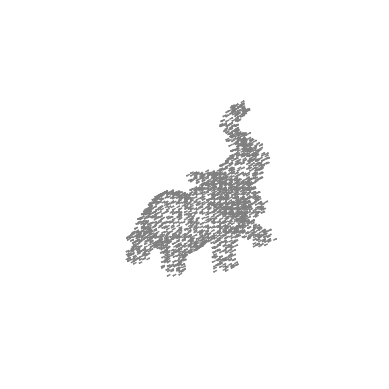

In [301]:
plot_vector_field(X, vector_heat_method(X, F, 0))

### One lazy elementary implementation with Pytorch

In [ ]:

# This code is given by the following repository: https://github.com/jakericedesigns/Pytorch-Heat-Method/. The implementation is pleasantly straigthforward and is put here as an example. Solve poisson and finite_div are taken from other papers.

def solve_poisson(img, iters=1000):
    LU = torch.tensor([[[[0, 1., 0],
                         [1, 0,  1],
                         [0, 1,  0]]]], dtype=img.dtype).to(img.device)

    BC = nn.ReplicationPad2d(1)
    solution = img
    for i in range(iters):
            solution = (img - nn.functional.conv2d(BC(solution), LU)) / -4.0
    return solution

def screened_poisson(img, timestep=.1, mass=.01, iters=1000):
    LU = torch.tensor([[[[0, -1., 0],
                         [-1, 0, -1],
                         [0, -1,  0]]]], dtype=img.dtype).to(img.device)

    BC = nn.ReplicationPad2d(1)  
    solution = img
    for i in range(iters):
            solution = (img - nn.functional.conv2d(BC(solution), LU * timestep)) / (mass + 4.0 * timestep)   
    return solution    

def finite_diff_grad(img):
    kernel_x = torch.tensor([[[[0, 0., 0],
                               [1, 0, -1],
                               [0, 0,  0]]]], dtype=img.dtype).to(img.device)

    kernel_y= torch.tensor([[[[0, 1,  0],
                              [0, 0,  0],
                              [0, -1, 0]]]], dtype=img.dtype).to(img.device)
    div_x = nn.functional.conv2d(img, kernel_x)
    div_y = nn.functional.conv2d(img, kernel_y)
    return torch.cat((div_x, div_y), 1) / 2.0

def finite_diff_div(grad):
    kernel_x = torch.tensor([[[[0, 0., 0],
                               [1, 0, -1],
                               [0, 0,  0]]]], dtype=grad.dtype).to(grad.device)
    kernel_y= torch.tensor([[[[0, 1,  0],
                              [0, 0,  0],
                              [0, -1, 0]]]], dtype=grad.dtype).to(grad.device)

    div_x = nn.functional.conv2d(grad[:,0:1,...], kernel_x)
    div_y = nn.functional.conv2d(grad[:,1:,...], kernel_y)
    return (div_x + div_y) / 4.0

# Now we can define the heat method function:

def heat_method(image, timestep=1.0, mass=.01, iters_diffusion=500, iters_poisson=1000):
    heat = screened_poisson(image, timestep, mass, iters_diffusion) #diffusion step
    grad = finite_diff_grad(heat) * -1 #inverted gradient
    grad = grad / grad.norm(dim=1) #normalize gradient
    div = finite_diff_div(grad)
    distance = solve_poisson(div, iters_poisson)
    return distance

def fitrange(x):
    c_max = torch.max(x)
    c_min = torch.min(x)
    return (x - c_min) / (c_max - c_min)



Below are some snippets for the code to work, from the same source:

In [ ]:
if __name__ == "__main__":
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    
    init_image = "H:\\Mon Drive\\Ai M2\\S2\\Minimal Paths\\Projet\\raie.jpg" ##Path to the image


    pil_image = Image.open(init_image).convert('RGB') #open image
    image = TF.to_tensor(pil_image).to(device).unsqueeze(0) #convert to tensor and add batch dimension

    #extract edges from our input images (this is a nice add by Jack Rice but not necessary for the heat method to work)
    edges = kornia.filters.canny(image)[1]
    
    #perform heat method to get depth map
    depth_map = heat_method(edges, timestep=0.1, mass=.01, iters_diffusion=500, iters_poisson=1000)


In [ ]:
# save the output images (change the path to save the images in the desired location)
#TF.to_pil_image(edges[0].cpu()).save('H:\\Mon Drive\\Ai M2\\S2\\Minimal Paths\\Projet\\edgesraie_out.jpg') 
#TF.to_pil_image(fitrange(depth_map)[0].cpu()).save('H:\\Mon Drive\\Ai M2\\S2\\Minimal Paths\\Projet\\depthraie_out.jpg')


### A more precise implementation- UNFINISHED SECTION (NOT USEFUL)

We actually need to be a bit more creative, as the initialisation is problematic. From https://github.com/nishi951/vector-heat-method/, we have some nice elementary functions.

In [ ]:
from plyfile import PlyData
import numpy as np

def extractVF_from_ply_file(file_path):
    # Read the PLY file
    plydata = PlyData.read(file_path)

    # Extract vertices
    V = []
    for d in ['x', 'y', 'z']:
        V.append(plydata['vertex'][d])
    V = np.column_stack(V)
    V = np.array(V, dtype=np.float64)
    
    # Extract faces
    F = []
    for face in plydata['face']['vertex_indices']:
        F.append(face[0])  # Assuming faces are triangles and getting only the first vertex index
        F.append(face[1])
        F.append(face[2])
    F = np.array(F, dtype=np.int64).reshape(-1, 3) + 1  # Reshape to Nx3 array and add 1 for 1-indexing
    
    return V, F

# Specify the file path
file_path = r'C:\Users\malki\Downloads\Vector_heat\Mesh\sphere.ply' #change this to the path of the PLY file

# Extract vertices and faces from the PLY file
V,F= extractVF_from_ply_file(file_path)


In [ ]:
def remove_duplicate_vertices(V, F):
    _, unique_indices = np.unique(V, axis=0, return_index=True)
    V = V[unique_indices]
    new_indices = {old_index: new_index for new_index, old_index in enumerate(unique_indices)}
    F = np.array([[new_indices[old_index] for old_index in face] for face in F])
    return V, F

def make_flatmesh(height, width, dx):
    N = height * width
    dy = dx * np.sqrt(3) / 2
    square_grid = np.zeros((height, width, 3))

    for y in range(height):
        for x in range(width):
            square_grid[y, x] = [dy * (y + 1), dx * (x + 1), 0]

    for row in range(height):
        if row % 2 == 1:
            for col in range(width):
                square_grid[row, col, 1] += dx / 2

    # Build faces
    F = []
    lin = np.arange(1, N + 1).reshape(height, width)
    for row in range(height - 1):
        if row % 2 == 0:
            for col in range(width - 1):
                F.append([lin[row, col], lin[row, col + 1], lin[row + 1, col]])
                F.append([lin[row + 1, col], lin[row, col + 1], lin[row + 1, col + 1]])
        else:
            for col in range(width - 1):
                F.append([lin[row, col], lin[row, col + 1], lin[row + 1, col + 1]])
                F.append([lin[row + 1, col], lin[row, col], lin[row + 1, col + 1]])

    V = square_grid.reshape((-1, 3))
    return V, F

def has_consistent_orientation(V, F):
    N = len(V)
    # Adjacent vertices should always appear in the opposite order across faces
    # or only once in one direction, over all faces
    E = {}
    for i, j, k in F:
        if i not in E:
            E[i] = []
        if j not in E:
            E[j] = []
        if k not in E:
            E[k] = []
        E[i].append(j)
        E[j].append(k)
        E[k].append(i)

    for i in range(1, N + 1):
        if len(E[i]) != len(set(E[i])):
            return False
    return True


def check_cycle(d, start):
    curr = start
    visited = set()
    while True:
        if curr not in d or curr in visited:
            return False
        visited.add(curr)
        curr = d[curr]
        if curr == start and len(visited) == len(d):
            return True

def get_interior_vertices_tangent_spaces(V, F, theta):
    N = len(V)
    Ord = {i: {} for i in range(1, N + 1)}  # Orderings on adjacent vertices
    Adj = {i: set() for i in range(1, N + 1)}  # Adjacency map
    print("Computing adjacency maps...")
    for i, j, k in tqdm(F, desc="Building adjacency maps"):
        if i not in Ord:
            Ord[i] = {}
        if j not in Ord:
            Ord[j] = {}
        if k not in Ord:
            Ord[k] = {}
        Ord[i][j] = k
        Ord[j][k] = i
        Ord[k][i] = j
        Adj[i].update([j, k])
        Adj[j].update([k, i])
        Adj[k].update([i, j])

    int_points = np.zeros(N, dtype=bool)  # Indicator function for interior vertices
    for i in range(1, N + 1):
        int_points[i - 1] = len(Ord[i]) > 0 and check_cycle(Ord[i], list(Ord[i].keys())[0])

    # Holds normalized angles to adjacent vertices
    phi = {i: {} for i in range(1, N + 1)}
    print("Computing tangent space angles...")
    for i in tqdm(range(1, N + 1), desc="Computing tangent space angles"):
        if not int_points[i - 1]:
            # Boundary points: set 0 for all adjacent vertices
            adj = list(Adj[i])
            for j in adj:
                phi[i][j] = 0
            continue

        adj = []
        norm_angles = []
        curr = list(Ord[i].keys())[0]
        total_angle = 0  # Expressed as an angle in radians
        while True:
            adj.append(curr)
            norm_angles.append(total_angle)
            next_vertex = Ord[i][curr]
            total_angle += theta[i][(curr, next_vertex)]
            if next_vertex == adj[0]:  # Loop complete
                # Normalize angle
                norm_angles = [angle * 2 * np.pi / total_angle for angle in norm_angles]
                for j, angle in zip(adj, norm_angles):
                    phi[i][j] = angle
                break
            curr = next_vertex
    return int_points, phi

def getExtrinsicTangentVector(phi, x, i, V):
    if x == 0:
        return np.zeros(3)
    vi = V[i, :]
    adj = phi[i]
    adj = sorted(adj.items(), key=lambda x: x[1])
    adj.append((adj[0][0], 2 * np.pi))
    theta = (np.angle(x) + 2 * np.pi) % (2 * np.pi)
    for ((j, theta_j), (k, theta_k)) in zip(adj[:-1], adj[1:]):
        if theta_j <= theta < theta_k:
            lmbda = (theta - theta_j) / (theta_k - theta_j)
            vj = V[j, :]
            vk = V[k, :]
            vlmbda = (1 - lmbda) * vj + lmbda * vk
            return (vlmbda - vi) / np.linalg.norm(vlmbda - vi) * np.abs(x)
    raise ValueError("Angle {} is wrong.".format(theta))

def getExtrinsicVectors(phi, X, V):
    Xtrinsic = np.zeros((len(X), 3))
    print("Computing extrinsic tangent vectors (for plotting)...")
    for i, x in enumerate(X):
        Xtrinsic[i, :] = getExtrinsicTangentVector(phi, x, i, V)
    return Xtrinsic

def plot_arrow_field(ax, V, Xtrinsic, k, label_vertices=False, **quiver_kwargs):
    x, y, z = V[:, 0], V[:, 1], V[:, 2]
    Xtrinsic_plot = Xtrinsic * k * np.sqrt(np.sum(Xtrinsic ** 2, axis=1))[:, np.newaxis]
    u, v, w = Xtrinsic_plot[:, 0], Xtrinsic_plot[:, 1], Xtrinsic_plot[:, 2]
    if label_vertices:
        for i in range(len(x)):
            ax.text(x[i], y[i], z[i], str(i))
    ax.quiver(x, y, z, u, v, w, **quiver_kwargs)

def plot_edges(ax, V, F, **plot_kwargs):
    for (i, j, k) in F:
        vi, vj, vk = V[i, :], V[j, :], V[k, :]
        for (r, s) in [(vi, vj), (vi, vk), (vj, vk)]:
            ax.plot([r[0], s[0]], [r[1], s[1]], [r[2], s[2]], **plot_kwargs)


With a little trick on the laws of cosine to compute the Laplacian.

In [ ]:
import cmath

def acos_complex(z):
    if z.real == 1 and z.imag == 0:
        return 0
    return -1j * cmath.log(z + 1j * cmath.sqrt(1 - z ** 2))

def heron(a, b, c):
    s = (a + b + c) / 2
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

def law_of_cosines(a, b, c):
    return acos_complex((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))

def check_cycle(d, start):
    L = 0  # Length of cycle
    curr = start
    visited = set()
    while True:
        if curr not in d or curr in visited:
            return False
        visited.add(curr)
        curr = d[curr]
        L += 1
        if curr == start and L == len(d):
            return True

def compute_r(phi, i, j):
    return np.exp(1j * (phi[j][i] + np.pi - phi[i][j]))

In [ ]:
from scipy.sparse import csr_matrix

def compute_laplacians(V, F, int_points, phi, theta):
    N = V.shape[0]
    Delta = csr_matrix((N, N))
    Delta_Nabla = csr_matrix((N, N), dtype=np.complex128)
    for i, j, k in tqdm(F, desc="Computing Laplacians"):
        a = 1 / np.tan(theta[i][(j, k)])
        b = 1 / np.tan(theta[j][(k, i)])
        c = 1 / np.tan(theta[k][(i, j)])
        rij = int_points[i] * compute_r(phi, i, j)
        rjk = int_points[j] * compute_r(phi, j, k)
        rki = int_points[k] * compute_r(phi, k, i)
        rji = np.conj(rij)
        rkj = np.conj(rjk)
        rik = np.conj(rki)
        Delta[[i, j, k], [i, j, k]] += -1 / 2 * np.array([[b + c, -c, -b],
                                                          [-c, c + a, -a],
                                                          [-b, -a, a + b]])
        Delta_Nabla[[i, j, k], [i, j, k]] += -1 / 2 * np.array([[b + c, -c * rji, -b * rik],
                                                                 [-c * rij, c + a, -a * rkj],
                                                                 [-b * rki, -a * rkj, a + b]])
    return Delta, Delta_Nabla

def preprocess(V, F):
    print("Removing duplicate vertices...")
    V, F = remove_duplicate_vertices(V, F)
    print("Checking consistent mesh orientation")
    if not has_consistent_orientation(V, F):
        raise ValueError("Ply lacks consistent orientation.")
    N = V.shape[0]  # Number of vertices
    A = csr_matrix((F.shape[0], 1))  # Face areas
    theta = {v: csr_matrix((N, N)) for v in range(1, N + 1)}  # unnormalized vertex angles
    M = np.zeros(N)  # Masses for each vertex
    E = csr_matrix((N, N))  # Edge lengths
    print("Computing angles and areas...")
    for f, (i, j, k) in tqdm(enumerate(F), desc="Computing Angles and Areas"):
        vi, vj, vk = V[i], V[j], V[k]
        ij = norm(vi - vj)
        jk = norm(vj - vk)
        ki = norm(vk - vi)
        E[i, j] = ij
        E[j, i] = ij
        E[j, k] = jk
        E[k, j] = jk
        E[k, i] = ki
        E[i, k] = ki
        # Area of face
        A[f] = heron(ij, jk, ki)
        # Associate 1/3 of the mass to each vertex
        M[i] += 1 / 3 * A[f]
        M[j] += 1 / 3 * A[f]
        M[k] += 1 / 3 * A[f]
        # Interior angles of face (first index is center of angle)
        theta[i][(j, k)] = law_of_cosines(ij, ki, jk)
        theta[i][(k, j)] = law_of_cosines(ij, ki, jk)
        theta[j][(i, k)] = law_of_cosines(ij, jk, ki)
        theta[j][(k, i)] = law_of_cosines(ij, jk, ki)
        theta[k][(i, j)] = law_of_cosines(ki, jk, ij)
        theta[k][(j, i)] = law_of_cosines(ki, jk, ij)

    print("Computing normalized angles for interior vertices...")
    int_points, phi = get_interior_vertices_tangent_spaces(V, F, theta)
    print("Computing laplacians...")
    Delta, Delta_Nabla = compute_laplacians(V, F, int_points, phi, theta)
    M = csr_matrix(diags(M, 0))
    return V, F, E, A, theta, M, phi, Delta, Delta_Nabla, int_points